In [ ]:
# Preparing data for the notebook
Following these steps will take about an hour, most of it processing time, and you will considerable disk space available.  50GB should be enough as of this writing.  The final result will be much smaller.

1. Download the raw datafile from https://sensorbot.org/sensordata/latest.db.gz.  This contains all Sensorbot and DEQ data for Portland.
2. Decompress the file.  
  * If you are on Linux or OSX, you can use gzip:  
  `gunzip latest.db.gz`
  * Windows cannot decompress gz files natively; you'll need to download a decompressor.  There are many packages available that will work, but the one I like is 7zip.  Get it at https://www.7-zip.org/download.html.  Unless you know otherwise, get the version for 64-bit Windows x64.
  * When you are finished decompressing, you should have a file called `sensorbot.db.
  * You can delete the `.gz` file if you want to reclaim some of your disk space.

`sensorbot.db` is a sqlite database file.  We'll need to run some queries to prepare the data for use in this notebook.  But first, you'll need a copy of the SQLite database software.  
  * On Linux or OSX, install it somehow.  The download page is at https://www.sqlite.org/download.html, or use apt-get sqlite3
  * On Windows, you can get SQLite at https://www.sqlite.org/download.html  Download the "bundle of command-line tools", open the zip file, and extract sqlite3.exe to the same folder where you stored `latest.db`.  There is nothing to install; the entire database package is included in this one file.

Run sqlite3.  You enter commands by typing them at the `sqlite>` prompt.

1. Open the database:  `.open sensorbot.db`
2. Run a query that will generate hourly summaries of the primary air quality data.  This query may take up to an hour to run.

```sql
DROP TABLE IF EXISTS ts_kv_hourly;

CREATE TABLE ts_kv_hourly (
    entity_id STRING NOT NULL,
    key INT NOT NULL,
    ts INT NOT NULL,
    val FLOAT NOT NULL
);

INSERT INTO ts_kv_hourly
SELECT entity_id, key, CAST (ts / (1000 * 60 * 60) AS INT) * (1000 * 60 * 60) AS ts_hourly, AVG(dbl_v) as val
FROM ts_kv AS tskv
WHERE tskv.key IN (
    SELECT key_id FROM ts_kv_dictionary WHERE key IN ('plantowerPM1concRaw', 'plantowerPM25concRaw', 'plantowerPM10concRaw', 'pm1', 'pm25', 'pm10', 'blackCarbon')
)
GROUP BY ts_hourly, entity_id, key;

-- Rename column
ALTER TABLE ts_kv_hourly RENAME COLUMN ts_hourly TO ts;

-- Adjust times to be on the same basis as DEQ's data
UPDATE ts_kv_hourly SET ts = ts + 60 * 60 * 1000 
JOIN device ON device.id = ts_kv_hourly.entity_id
WHERE type != 'DEQ';   
```

If you are concerned about disk space, now that you have the hourly summaries, you can delete the original data before we build our indices, which will consume more disk space.

```sql
DROP table ts_kv;   -- Deletes the largest data table
VACUUM;             -- Rewrites the database to reclaim your disk space
```

If you have plenty of diskspace and want to keep all the data around, you can always delete it later using the commands above.

Next we'll build some indices which will improve the performance of the database.  These will increase the size of the database, and are optional, but it is highly recommended you don't skip this step.

```sql
-- Create hourly indices
CREATE INDEX ts_kv_hourly_id_key ON ts_kv_hourly(entity_id, key);
CREATE INDEX ts_kv_hourly_data_ts ON ts_kv_hourly(ts);
CREATE INDEX ts_kv_hourly_data_key ON ts_kv_hourly(key);
```

If you are keeping the main data table around, and want to work with it, it will be helpful to build some indices for it as well.  Note that these will take considerable disk space and will take a while to generate, but the indices will make common queries on the main data much faster.  This step is entirely optional.

```sql
-- Index ts_kv (optional -- obviously won't work if you deleted ts_kv above!)
CREATE INDEX ts_kv_id_key ON ts_kv_hourly(entity_id, key);
CREATE INDEX ts_kv_ts ON ts_kv_hourly(ts);
```

Finally, we'll create some views that will make working with the data simpler.

```sql
DROP VIEW IF EXISTS TSKV;
CREATE VIEW tskv AS
SELECT device.name, device.type, ts, dict.key, val FROM ts_kv_hourly AS tskv 
INNER JOIN ts_kv_dictionary AS dict ON tskv.key = dict.key_id
INNER JOIN device ON device.id = tskv.entity_id;
```


In [150]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
# import missingno as msno
import numpy as np
import seaborn as sns
# %matplotlib inline          # Forces display of graphs inline in the notebook


con = sqlite3.connect(R"Q:\sensorbot\test\sensorbot.db")
# cur = con.cursor()

In [207]:
# Create a dataframe with the Birdhouse data
df2 = pd.read_sql("""
    select h.ts, h.val, d.name 
    from ts_kv_hourly as h 
    join device as d on d.id = h.entity_id 
    where key = (select key_id from ts_kv_dictionary where key in('plantowerPM25concRaw')) 
    order by ts
""", con)
df2.ts = pd.to_datetime(df2.ts, unit="ms")
df2 = df2.set_index("ts") 
# grouped = df2.groupby(["name"])         # Group data by name
df2.head()



,val,name
ts,,
2018-06-30,2.747222,Birdhouse 010
2018-06-30,2.110556,Birdhouse 005
2018-06-30,2.508824,Birdhouse 013
2018-06-30,2.576111,Birdhouse 012
2018-06-30,2.803125,Birdhouse 003


In [206]:
# Create a dataframe with the DEQ reference data
deq = pd.read_sql("""
    select ts, dbl_v as val, d.name 
    from ts_kv_deq 
    join device as d on d.id = entity_id 
    where key = (select key_id from ts_kv_dictionary where key = 'pm25')
    order by ts
""", con)
deq.ts = pd.to_datetime(deq.ts, unit="ms")
deq = deq.set_index("ts") 
# deq = df2.groupby(["name"])         # Group data by name
deq.head()

,val,name
ts,,
2018-04-28 08:00:00,12.7,DEQ (SEL)
2018-04-28 09:00:00,13.7,DEQ (SEL)
2018-04-28 10:00:00,14.4,DEQ (SEL)
2018-04-28 11:00:00,15.1,DEQ (SEL)
2018-04-28 12:00:00,14.0,DEQ (SEL)


In [111]:
df = pd.read_sql("select distinct(ts), 1 as val from ts_kv_hourly where entity_id = (select id from device where name = 'Birdhouse 014') order by ts limit 500", con)
# df = pd.read_sql("select d.name, distinct(ts), 1 as val from ts_kv_hourly as h join device as d on d.id = h.entity_id", con)
df.ts = pd.to_datetime(df.ts, unit="ms")
df = df.set_index("ts")  
df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1], freq='1H'))        # Create entries in the gaps with value NaN



,val
2018-08-06 05:00:00,1.0
2018-08-06 06:00:00,NaN
2018-08-06 07:00:00,NaN
2018-08-06 08:00:00,NaN
2018-08-06 09:00:00,NaN
...,...
2018-08-27 07:00:00,1.0
2018-08-27 08:00:00,1.0
2018-08-27 09:00:00,1.0
2018-08-27 10:00:00,1.0


In [ ]:
# Show the missing data ==> red is present, blue is missing
plt.figure(figsize=(6, 1))
plt.bar(df.index, np.ones(len(df)), color=[['r','b'][i == 1] for i in df['val']])
# df.index
plt.show()
# [[4,5][i] for i in df['1']]


In [98]:
# l = list(grouped)
# type(l[0][1])



pandas.core.frame.DataFrame

In [174]:
sns.set_theme()     # Set theme of our plts



# datasets = list(df2.groupby(["name"])) + list(deq.groupby(["name"]))    # List[Tuple[str, DataFrame]]
datasets = df2 #.groupby(["name"])
plots = len(datasets)

cols = 3                         # How many columns do we want for our data
rows = (plots - 1) // cols + 1   # Compute number of rows; plots is number of plots we'll have
hsize = 5                        # Width of each plot (inches)
vsize = 3                        # Height of each plot (inches)
y_axis_max = 150                 # Max value to show on the y-axis (to prevent data from being swamped by smoke days, for example)

# Define a figure (called fig) composed of a series of subplots arranged in a grid, each the size of hsize x vsize,
# sharing a common set of x and y axes.
# fig, subplots = plt.subplots(rows, cols, figsize=(hsize * cols, rows * vsize), sharex=True, sharey=True)


# datasets = df2.groupby(["name"])  #list(df2.groupby(["name"])) + list(deq.groupby(["name"]))    # List[Tuple[str, DataFrame]]
fg = sns.FacetGrid(df2, row="name") # , row="name")
fg.map(sns.lineplot, data=datasets, hue=key)
g.set_axis_labels("", "µg/m³")


# # plt.figure(figsize=(hsize * cols, rows * vsize))    # Set the overall figure size


# for i, (name, data) in enumerate(datasets):          # i will be incremeneting counter, which we'll use as a subplot index
#     row = i // cols
#     col = i % cols



# datasets[0][1]

# sns.lineplot(data=data, paette="tab10", linewidth=1)


KeyboardInterrupt: 

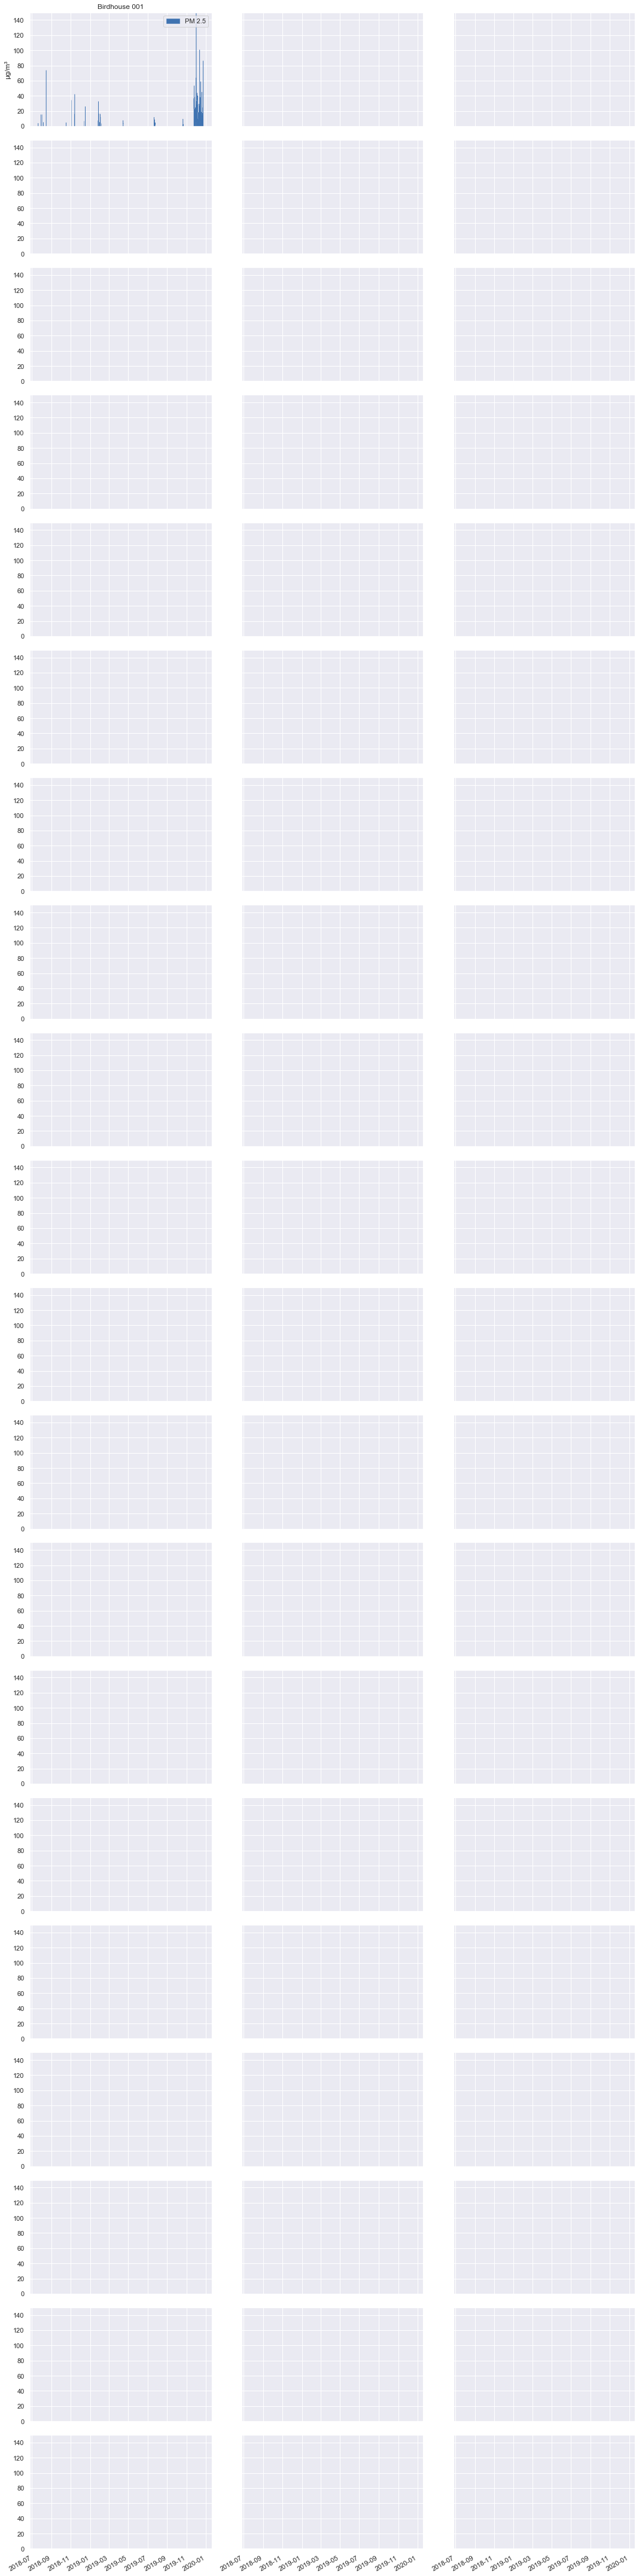

In [ ]:

# grouped = df2.groupby(["name"])         # Group data by name
datasets = list(df2.groupby(["name"])) + list(deq.groupby(["name"]))    # List[Tuple[str, DataFrame]]
plots = len(datasets)

cols = 3                         # How many columns do we want for our data
rows = (plots - 1) // cols + 1   # Compute number of rows; plots is number of plots we'll have
hsize = 5                        # Width of each plot (inches)
vsize = 3                        # Height of each plot (inches)
y_axis_max = 150                 # Max value to show on the y-axis (to prevent data from being swamped by smoke days, for example)

# Define a figure (called fig) composed of a series of subplots arranged in a grid, each the size of hsize x vsize,
# sharing a common set of x and y axes.
fig, subplots = plt.subplots(rows, cols, figsize=(hsize * cols, rows * vsize), sharex=True, sharey=True)

# plt.figure(figsize=(hsize * cols, rows * vsize))    # Set the overall figure size


for i, (name, data) in enumerate(datasets):          # i will be incremeneting counter, which we'll use as a subplot index
    row = i // cols
    col = i % cols

    subplt = subplots[row][col]

    r = pd.date_range(start=xxx.index[0], end=xxx.index[-1], freq='1H')

    if not name.startswith("DEQ"):
        data = data.reindex(r)        # Create entries in the gaps with value NaN
    
    # subplt.plot(deq.index, deq.val, color="green")  # Add the DEQ data as a reference line

    color = "#5A9A55" if name.startswith("DEQ") else "#3F73B1"   # Choose the line color based on dataset name

    lw = .5  # points

    data_for_plotting = data.val.fillna(0)      # Saborn deletes any NaN values, but we want them to plot as 0, so make the replacement here.
                                                # Unfortunately, this corrupts the data for doing any analysis, so put the results in a plottong-only df.
    # print(df2.head())
    # print(data.head())
    # print(data_for_plotting.head())

    # subplt.stackplot(data.index, data.val, color="red")
    subplt.stackplot(data.index, data.val, color=color, linewidth=.5)

    # sns.lineplot(ax=subplt, data=data_for_plotting, linewidth=.1, color="red")

    # subplt.plot(data.index, data.val, color=color, linewidth=lw, )
    # subplt.fill_between(data.index, data.val, 0, facecolor=color, linewidth=1000 )    # Fills the area under the curve   

    subplt.set_title(name)                          # Chart title ==> Device name
    subplt.legend(["PM 2.5"])                       # Change the legend text
    subplt.set_xlabel("")                           # No need to label -- dates are obvious
    if col == 0:
        subplt.set_ylabel("µg/m³")                  # Units on the y-axis, but only on the first in the row
    # subplt.set_label("PM 2.5")                      # Label for the primary data-series
    subplt.set_ylim(bottom=0, top=y_axis_max)       # Set data range for y-axis

    break

fig.autofmt_xdate()                                 # Make the dates at the bottom look better
plt.tight_layout()

plt.show()   

# TODO: Add smoke ranges
# TODO: Remove calibration data


In [ ]:
df2.index.min()


In [ ]:
con.close()

In [ ]:
# missing = df.notnull()
# missing
# msno.matrix(df)



In [ ]:
7*8